In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
import tensorflow
from tensorflow.keras.models import load_model
from tensorflow.python.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import pickle

### This Model will try to improve recall but will pay decreasing accuracy

In [2]:
## Load the dataset
data=pd.read_csv("Churn_Modelling.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
data['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [5]:
## Preprocess the data
### Drop irrelevant columns
data=data.drop(['RowNumber','CustomerId','Surname'],axis=1)
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [6]:
## Encode categorical variables
label_encoder_gender=LabelEncoder()
data['Gender']=label_encoder_gender.fit_transform(data['Gender'])
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,1,39,5,0.00,2,1,0,96270.64,0
9996,516,France,1,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,0,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,1,42,3,75075.31,2,1,0,92888.52,1


In [7]:
## Onehot encode 'Geography
from sklearn.preprocessing import OneHotEncoder
onehot_encoder_geo=OneHotEncoder()
geo_encoder=onehot_encoder_geo.fit_transform(data[['Geography']]).toarray()
geo_encoder

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [8]:
onehot_encoder_geo.get_feature_names_out(['Geography'])

array(['Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype=object)

In [9]:
geo_encoded_df=pd.DataFrame(geo_encoder,columns=onehot_encoder_geo.get_feature_names_out(['Geography']))
geo_encoded_df

,Geography_France,Geography_Germany,Geography_Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
9995,1.0,0.0,0.0
9996,1.0,0.0,0.0
9997,1.0,0.0,0.0
9998,0.0,1.0,0.0


In [10]:
## Combine one hot encoder columns with the original data
data=pd.concat([data.drop('Geography',axis=1),geo_encoded_df],axis=1)
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [11]:
## Save the encoders and sscaler
with open('label_encoder_gender.pkl','wb') as file:
    pickle.dump(label_encoder_gender,file)

with open('onehot_encoder_geo.pkl','wb') as file:
    pickle.dump(onehot_encoder_geo,file)


In [12]:
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [13]:
## DiVide the dataset into indepent and dependent features
X=data.drop('Exited',axis=1)
y=data['Exited']

## Split the data in training and tetsing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [14]:
# 1. Scale features to have similar scales
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Apply SMOTEENN to have same quantity of cases per label
#smote_enn = SMOTEENN(random_state=42)
#X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)


In [15]:
# Check the shapes of the train data
print("Resampled X_train shape:", X_train.shape)
print("Resampled y_train shape:", y_train.shape)

Resampled X_train shape: (8000, 12)
Resampled y_train shape: (8000,)


In [16]:
with open('scaler.pkl','wb') as file:
    pickle.dump(scaler,file)

In [17]:
data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,0,1.0,0.0,0.0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,1.0,0.0,0.0
9997,709,0,36,7,0.00,1,0,1,42085.58,1,1.0,0.0,0.0
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,0.0,1.0,0.0


### ANN Implementation

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
import datetime

In [19]:
(X_train.shape[1],)

(12,)

In [20]:
## Build Our ANN Model with 3 hiden layers and 3 droput layers
model=Sequential([
    Dense(64,activation='elu',input_shape=(X_train.shape[1],)), ## HL1 Connected wwith input layer
    Dropout(0.2),  # Dropout Layer after Hidden Layer 1
    Dense(32,activation='elu'), ## HL2
    Dropout(0.2),  # Dropout Layer after Hidden Layer 2
    Dense(1,activation='sigmoid')  ## output layer
])

In [21]:
#Check number of parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
## compile the model (to do forward and backward propagation)
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
## Set up the Tensorboard to see all the logs for each epoch
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorflow_callback=TensorBoard(log_dir=log_dir,histogram_freq=1)

In [24]:
## Set up Early Stopping to stop when more epochs aren't needed due to loss is not decreasing more
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [25]:
### Train the model
history=model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  epochs=100, batch_size=32,
                  #class_weight=class_weight_dict,
                  callbacks=[tensorflow_callback,early_stopping_callback]
)

Epoch 1/100


250/250 [==============================] - 1s 2ms/step - loss: 0.4253 - accuracy: 0.8152 - val_loss: 0.3592 - val_accuracy: 0.8500
Epoch 2/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3832 - accuracy: 0.8388 - val_loss: 0.3700 - val_accuracy: 0.8380
Epoch 3/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3705 - accuracy: 0.8440 - val_loss: 0.3524 - val_accuracy: 0.8555
Epoch 4/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3678 - accuracy: 0.8493 - val_loss: 0.3449 - val_accuracy: 0.8580
Epoch 5/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3658 - accuracy: 0.8505 - val_loss: 0.3425 - val_accuracy: 0.8540
Epoch 6/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3633 - accuracy: 0.8545 - val_loss: 0.3427 - val_accuracy: 0.8630
Epoch 7/100
250/250 [==============================] - 0s 1ms/step - loss: 0.3610 - accuracy: 0.8499 - val_loss: 0.3467 - val_accuracy: 0.85

In [26]:
model.save('model.keras')

In [27]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Convert predictions to class labels
y_train_pred_classes = np.round(y_train_pred).astype(int)
y_test_pred_classes = np.round(y_test_pred).astype(int)

# Calculate metrics for binary classification
# Ensure y_train and y_test are binary (0 or 1)

# Training metrics
accuracy_train = accuracy_score(y_train, y_train_pred_classes)
precision_train = precision_score(y_train, y_train_pred_classes)
recall_train = recall_score(y_train, y_train_pred_classes)
f1_train = f1_score(y_train, y_train_pred_classes)
auc_train = roc_auc_score(y_train, y_train_pred)

# Testing metrics
accuracy_test = accuracy_score(y_test, y_test_pred_classes)
precision_test = precision_score(y_test, y_test_pred_classes)
recall_test = recall_score(y_test, y_test_pred_classes)
f1_test = f1_score(y_test, y_test_pred_classes)
auc_test = roc_auc_score(y_test, y_test_pred)

# Print metrics
print("Training Accuracy:", accuracy_train)
print("Training Precision:", precision_train)
print("Training Recall:", recall_train)
print("Training F1 Score:", f1_train)
print("Training AUC:", auc_train)

print("Testing Accuracy:", accuracy_test)
print("Testing Precision:", precision_test)
print("Testing Recall:", recall_test)
print("Testing F1 Score:", f1_test)
print("Testing AUC:", auc_test)

63/63 [==============================] - 0s 677us/step
Training Accuracy: 0.86425
Training Precision: 0.7961783439490446
Training Recall: 0.4562043795620438
Training F1 Score: 0.580046403712297
Training AUC: 0.8695652631611184
Testing Accuracy: 0.8585
Testing Precision: 0.7412280701754386
Testing Recall: 0.4300254452926209
Testing F1 Score: 0.5442834138486312
Testing AUC: 0.8616073761263935


In [28]:
#Create confusion matrix
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
train_confusion_matrix = confusion_matrix(y_train, y_train_pred_classes)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred_classes)

print("Training Confusion Matrix:")
print(train_confusion_matrix)

print("Testing Confusion Matrix:")
print(test_confusion_matrix)

Training Confusion Matrix:
[[6164  192]
 [ 894  750]]
Testing Confusion Matrix:
[[1548   59]
 [ 224  169]]


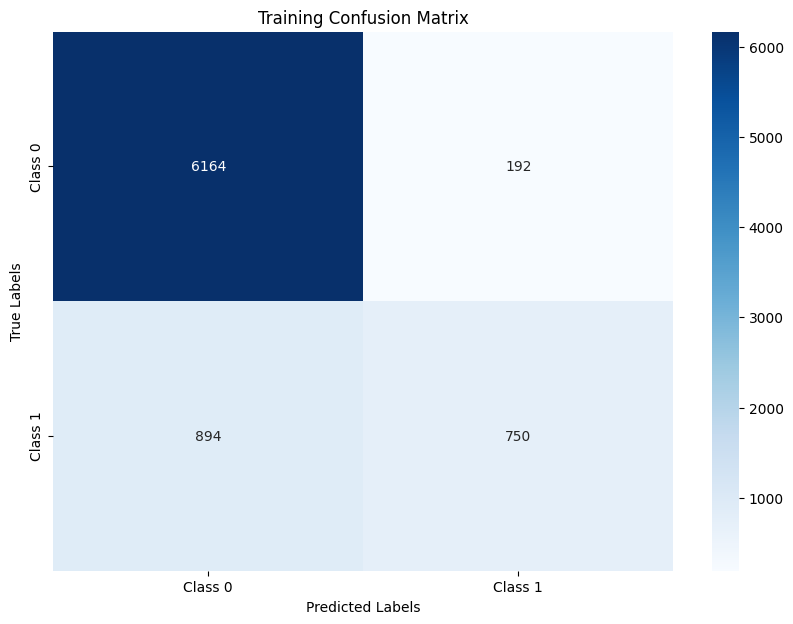

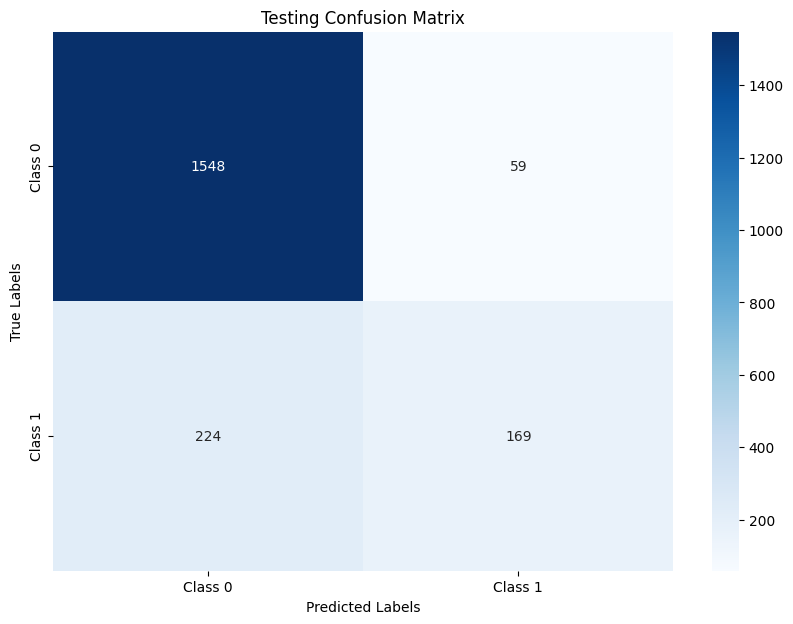

In [29]:
#visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Define labels based on your dataset
labels = ['Class 0', 'Class 1']  # Update with your actual class labels

# Plot confusion matrices
plot_confusion_matrix(train_confusion_matrix, labels, 'Training Confusion Matrix')
plot_confusion_matrix(test_confusion_matrix, labels, 'Testing Confusion Matrix')

In [30]:
# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('model.keras')

In [35]:
## Load Tensorboard Extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [37]:
%tensorboard --logdir logs/fit  --port 6007

In [33]:
### Load the pickle file
